## ClearGrasp

In [1]:
import os
import sys
sys.path.append('/root/Workspace/project/code_bat/transparent/transparent-30')
import torch
import torch.utils.data
from lib.networks.network import PoseNet
from lib.networks.TRPES import TRPESNet
from datasets.cleargrasp.dataset import PoseDataset
from datasets.cleargrasp.dataset import BathPoseDataset as BathPoseDataset_trans
from train import _init_paramter
from lib.transform.allocentric import allo_to_ego_mat_torch
import lib.proj_bboxs as pbr

In [2]:
import matplotlib.pyplot as plt

In [3]:
_TEPS = torch.finfo(torch.float).eps * 4.0
def quaternion_matrix_torch(quaternion):
    """
    Return homogeneous rotation matrix from quaternion.
    undifferentiable
    """
    q = quaternion.clone().detach().type(torch.float64)
    device = q.device
    n = torch.dot(q, q)
    if n < _TEPS:
        return torch.eye(4)
    q *= torch.sqrt(2.0 / n)
    q = torch.outer(q, q)
    return torch.tensor([
        [1.0-q[2, 2]-q[3, 3],     q[1, 2]-q[3, 0],     q[1, 3]+q[2, 0], 0.0],
        [    q[1, 2]+q[3, 0], 1.0-q[1, 1]-q[3, 3],     q[2, 3]-q[1, 0], 0.0],
        [    q[1, 3]-q[2, 0],     q[2, 3]+q[1, 0], 1.0-q[1, 1]-q[2, 2], 0.0],
        [                0.0,                 0.0,                 0.0, 1.0]], device=device)

In [4]:
num_points = 1000
num_obj = 5
bs = 1

In [5]:
checkpoint = '/root/Source/ymy_dataset/trained/instance/cleargrasp/30/pose_model_243_0.006388953372904386.pth'
dataset_root = '/root/Source/ymy_dataset/cleargrasp'

estimator = TRPESNet(num_points=num_points, num_obj=num_obj)
estimator.cuda()
ckpt_dict = torch.load(checkpoint)
ckpt_dict = {k.replace('module.', ''): v for k, v in ckpt_dict.items()}
estimator.load_state_dict(ckpt_dict)

test_dataset = BathPoseDataset_trans('test', num_points, False, dataset_root, 0.0, False)
testdataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)
data_iter = testdataloader.__iter__()

In [20]:
def get_activation(name):
    def hook(model, input, output):
        # 如果你想feature的梯度能反向传播，那么去掉 detach（）
        activation[name] = output.detach()
    return hook

features_1 = []
def layer_hook_1(module, input, output): 
    features_1.append(output[-1].clone().detach())
    
features_2 = []
def layer_hook_2(module, input, output): 
    features_2.append(output[-1].clone().detach())

features_3 = []
def layer_hook_3(module, input, output): 
    features_3.append(output[0].detach().clone())

features_4 = []
def layer_hook_4(module, input, output): 
    features_4.append(output[-1].detach().clone())
    
hook1 = estimator.n_con_1.register_forward_hook(layer_hook_1)
hook2 = estimator.d_con_1.register_forward_hook(layer_hook_2)
hook3 = estimator.backbone.register_forward_hook(layer_hook_3)
hook4 = estimator.backbone.register_forward_hook(layer_hook_4)

tensor(1.1510, device='cuda:0') tensor(0.2057, device='cuda:0')
tensor(0.3859) tensor(0.3250)


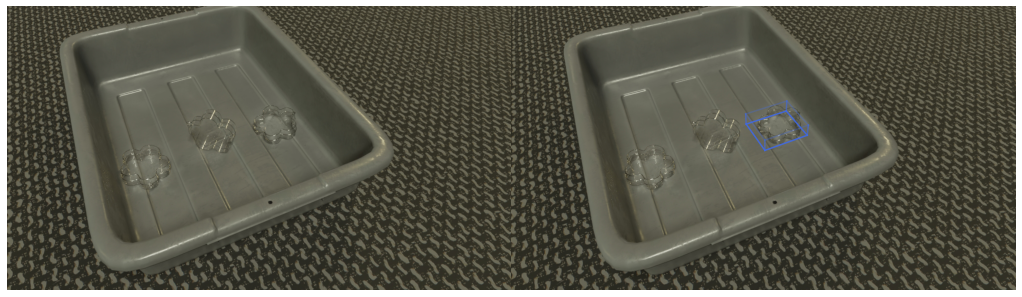

In [33]:
while True:
    datas = data_iter.__next__()
    if not datas['flag'].item():
        continue
    else:
        break
        
ori_img = test_dataset.ori_img
plt.figure(figsize=(14, 8))
plt.subplot(121)
plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.imshow(ori_img)
plt.subplot(122)
plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.imshow(ori_img)
with torch.no_grad():
    pred_r, pred_t, pred_c, pred_normal, pred_depth, pred_mask = estimator(
        datas['img_cropeds'].cuda(),
        datas['intrinsic'].cuda(),
        datas['xmaps'].cuda(),
        datas['ymaps'].cuda(),
        datas['d_scales'].cuda(),
        datas['obj_ids'].cuda()
    )
    
    pred_r, pred_t, pred_c, pred_normal, pred_depth, pred_mask = (
        pred_r.detach(),
        pred_t.detach(),
        pred_c.detach(),
        pred_normal.detach(),
        pred_depth.detach(),
        pred_mask.detach()
    )
    s_zoom = datas['s_zoom'].item()
    pred_r = pred_r / torch.norm(pred_r, dim=2).view(1, num_points, 1)
    
    fx, fy, cx, cy = datas['intrinsic'][0]/s_zoom
    
    pred_c = pred_c.view(bs, num_points)
    how_max, which_max = torch.max(pred_c, 1)
    pred_t = pred_t.view(bs * num_points, 1, 3)
    R = pred_r[0][which_max[0]].view(-1)
    T = pred_t[which_max[0]].type(torch.float)
    R = quaternion_matrix_torch(R).type(torch.float)[:3, :3]
    R = allo_to_ego_mat_torch(T, R.unsqueeze(0)).squeeze(0).cpu()
    T = T.cpu()

model_points = datas['model_points'][0]
regress_pred = torch.mm(model_points, R.T)+ T

xmin, xmax =  model_points[:, 0].min(), model_points[:, 0].max()
ymin, ymax =  model_points[:, 1].min(), model_points[:, 1].max()
zmin, zmax =  model_points[:, 2].min(), model_points[:, 2].max()
# bbox3d = torch.tensor([
#     [xmin, ymin, zmin],
#     [xmax, ymin, zmin],
#     [xmin, ymax, zmin],
#     [xmax, ymax, zmin],
#     [xmin, ymin, zmax],
#     [xmax, ymin, zmax],
#     [xmin, ymax, zmax],
#     [xmax, ymax, zmax],
# ]).cpu()

bbox3d = torch.tensor([
    [xmax, ymax, zmax],
    [xmax, ymax, zmin],
    [xmin, ymax, zmax],
    [xmin, ymax, zmin],
    [xmax, ymin, zmax],
    [xmax, ymin, zmin],
    [xmin, ymin, zmax],
    [xmin, ymin, zmin],
])

bbox3d = bbox3d @ R.T + T

u = regress_pred[:, 0] * fx / regress_pred[:, 2] + cx
v = regress_pred[:, 1] * fy / regress_pred[:, 2] + cy

bu = bbox3d[:, 0] * fx / bbox3d[:, 2] + cx
bv = bbox3d[:, 1] * fy / bbox3d[:, 2] + cy

# plt.plot(
# bu[[0, 0, 0, 3, 3, 3, 4, 4, 7, 7]],
# bv[[1, 2, 4, 1, 2, 7, 5, 6, 5, 6]],
# )
start_list1 = [4, 5, 6, 7]
end_list1 =   [5, 7, 4, 6]

start_list2 = [0, 1, 2, 3]
end_list2 =   [4, 5, 6, 7]

start_list3 = [0, 1, 2, 3]
end_list3 =   [1, 3, 0, 2]
for st, end in zip(start_list1, end_list1):
    plt.plot(bu[[st, end]], bv[[st, end]], c='royalblue', alpha=0.3)

for st, end in zip(start_list2, end_list2):
    plt.plot(bu[[st, end]], bv[[st, end]], c='royalblue', alpha=0.6)
    
for st, end in zip(start_list3, end_list3):
    plt.plot(bu[[st, end]], bv[[st, end]], c='royalblue', alpha=0.9)
# plt.scatter(u.cpu(),v.cpu(), s=0.5, alpha=0.5, c='g')

print(pred_depth.max(), pred_depth.min())
print(datas['depths'][0].max(), datas['depths'][0].min())
plt.show()

# Show lantecode

## 前128层特征

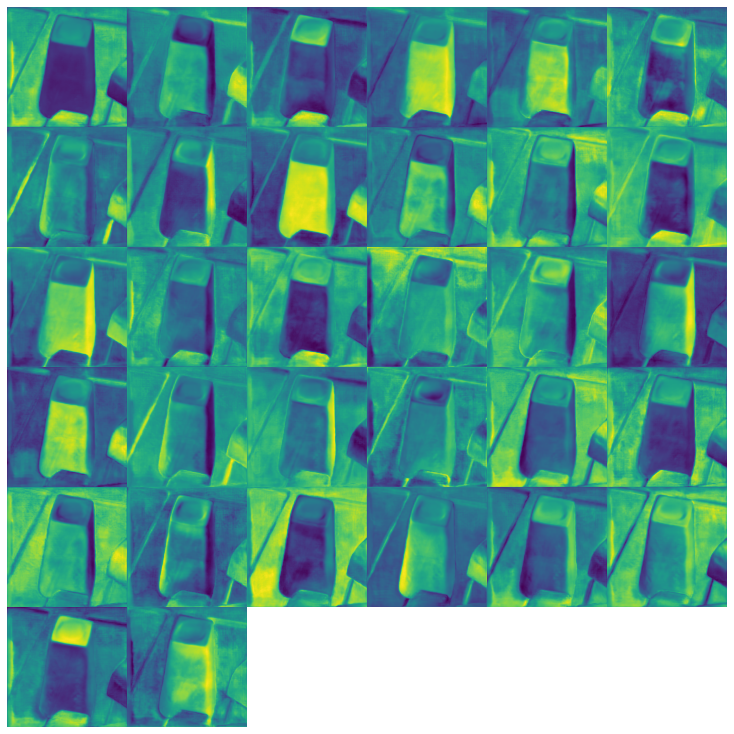

In [22]:
fes = features_1[0].cpu().numpy()
plt.figure(figsize=(10, 10))
for i in range(1, 33):
    plt.subplot(6,6,i)
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.imshow(fes[i-1])
plt.show()

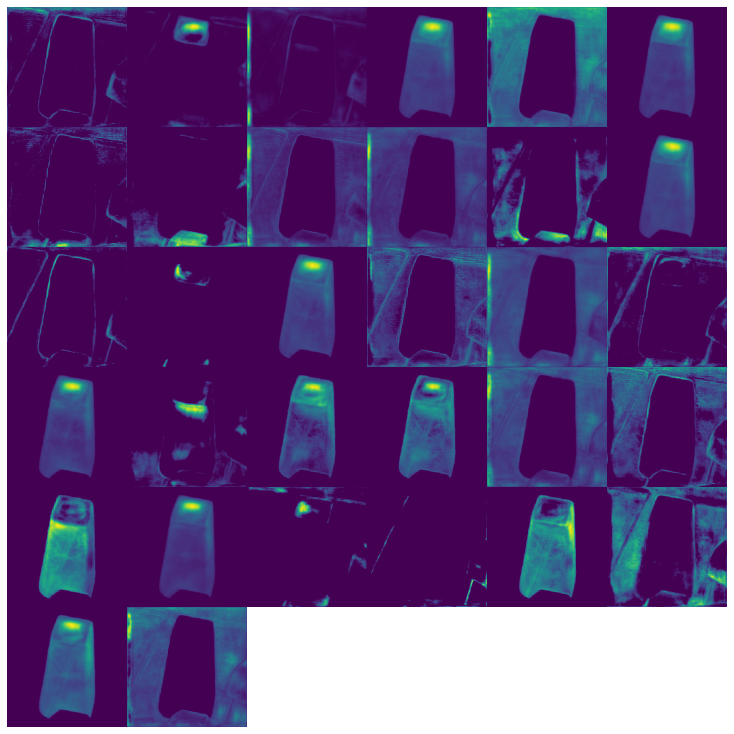

In [23]:
# depth
fes = features_2[0].cpu().numpy()
plt.figure(figsize=(10, 10))
for i in range(1, 33):
    plt.subplot(6,6,i)
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.imshow(fes[i-1])
plt.show()

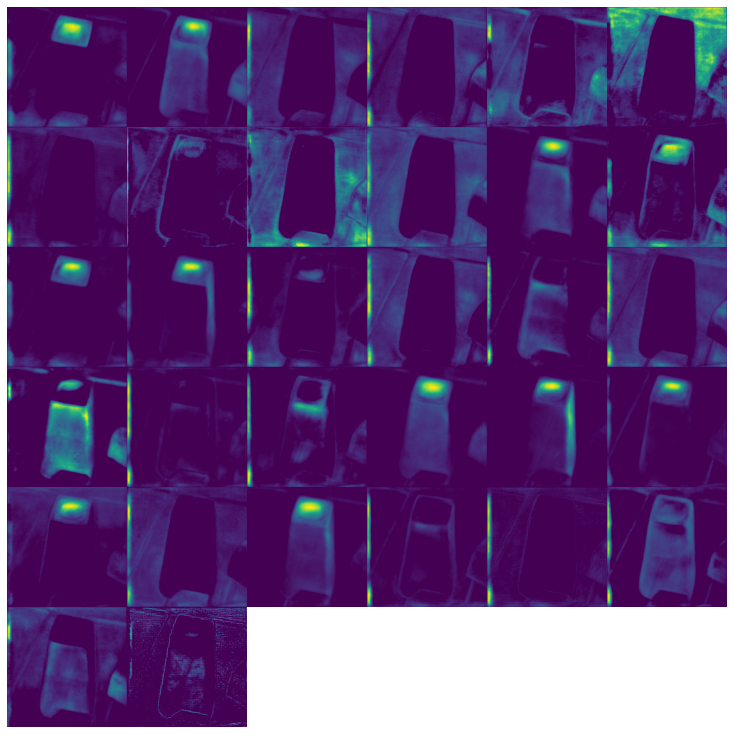

In [24]:
# rgb
fes = features_3[0][0].cpu().numpy()
plt.figure(figsize=(10, 10))
for i in range(1, 33):
    plt.subplot(6,6,i)
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.imshow(fes[i-1])
plt.show()

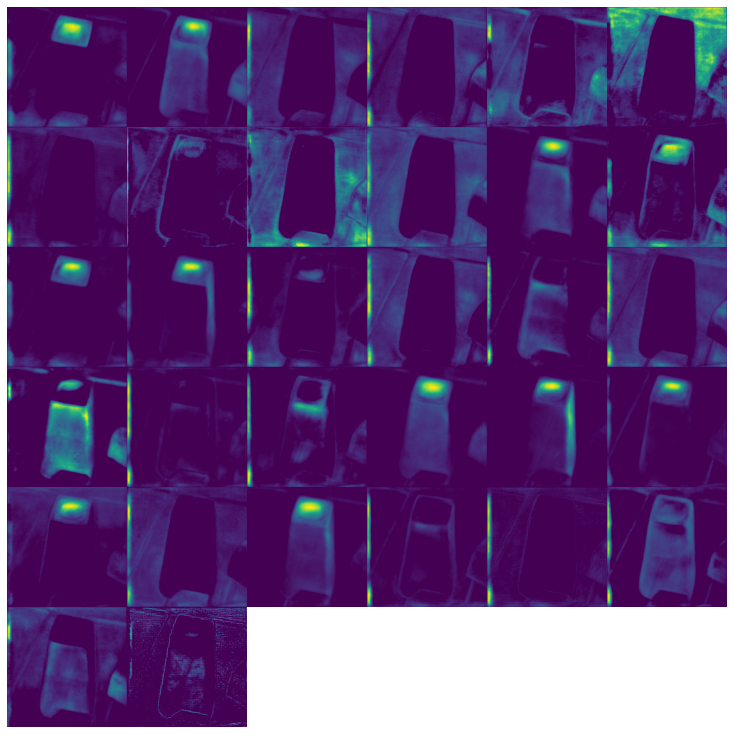

In [25]:
# depth
fes = features_4[0][0].cpu().numpy()
plt.figure(figsize=(10, 10))
for i in range(1, 33):
    plt.subplot(6,6,i)
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.imshow(fes[i-1])
plt.show()